<a href="https://colab.research.google.com/github/lrssv/TimeSeriesForecastingCOVID19/blob/master/Multi_Step_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-step ARIMA for COVID-19 Infections Forecast


Como o SARIMA faz várias previsões a frente?

Experimento:
- dados de treino: 30 dias inicial / depois ++ 1 dia
- escolher três parametros aleatóriamente -> plotar resultados e erros
- horizonte de previsão: 1, 7 e 30 dias  

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import timedelta
import itertools
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Defining the parameter search space

ARIMA has the following parameters:

p (lag order): number of lag observations included in the model

d (degree of differencing): number of times that the raw observations are differenced

q (order of moving average): size of the moving average window

In [2]:
# Get data
series = pd.read_csv('/content/drive/My Drive/who dataset/up_dataset_who.csv',header=0, parse_dates=[0], index_col=0, squeeze=True)

# The term bfill means that we use the value before filling in missing values
series = pd.Series(series.fillna(series.bfill()))


print(series)

date_epicrv
2020-01-11 00:00:00+00:00       41
2020-01-12 00:00:00+00:00        0
2020-01-13 00:00:00+00:00        1
2020-01-14 00:00:00+00:00        1
2020-01-15 00:00:00+00:00        0
                             ...  
2020-04-30 00:00:00+00:00    72955
2020-05-01 00:00:00+00:00    85016
2020-05-02 00:00:00+00:00    90560
2020-05-03 00:00:00+00:00    84003
2020-05-04 00:00:00+00:00    86029
Name: 0, Length: 115, dtype: int64


In [3]:
def run_tests(series,cold_start=30,steps_ahead=1,configurations=[(1,1,1)]):

  begin = series.index.min() + timedelta(days=0)
  # List of all dates from begin + cold_start to end
  date_list = [begin + timedelta(days=cold_start) + timedelta(days=x) for x in range(len(series)-steps_ahead-cold_start)]


  results = []
  ex_count = 0
  for c in configurations:
    for date in tqdm(date_list):
      # Select data
      train = series[begin:date] 

      f_date = date + timedelta(days=steps_ahead) # The day we want the forecast for

      # Fit ARIMA
      try: # Try to use ARIMA
        mod = sm.tsa.statespace.SARIMAX(train, order=c) # Selected the parameters randomly
        res = mod.fit(disp=False)
        # Get forecast
        forecast = res.forecast(days=steps_ahead)[0] 
        results.append([f_date,forecast,series[f_date],np.abs(series[f_date]-res.forecast()[0]),'arima',c])
      except: # Use persistence
        results.append([f_date,series[date],series[f_date],np.abs(series[f_date]-series[date]),'persistence',None])
        ex_count = ex_count+1


  print('ARIMA ERRORS: ' + str(ex_count))

  return results

In [4]:
def plot_results(series,results,steps_ahead):

  plt.rcParams.update({'font.size': 15})
  figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

  dates = [r[0] for r in results]
  error = [r[3] for r in results]
  forecasts = [r[1] for r in results]

  persist = [series[d + timedelta(days=-steps_ahead)] for d in dates]

  plt.plot(dates,error,'--')
  plt.plot(series,'-')
  plt.plot(dates,forecasts,'-')
  plt.plot(dates,persist,'-')
  
  plt.legend(['Error','Observed','Forecast','Persist'])


  print('MAE: {} ESTD: {}'.format(np.mean(error),np.std(error)))

In [5]:
def plot_error(series,results,steps_ahead):
  plt.rcParams.update({'font.size': 15})
  figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

  dates = [r[0] for r in results]
  error = [r[3] for r in results]
  forecasts = [r[1] for r in results]

  persist = [series[d + timedelta(days=-steps_ahead)] for d in dates]
  error_persist = [np.abs(series[d] - p) for d,p in zip(dates,persist)] 

  plt.plot(dates,error,'--')
  plt.plot(dates,error_persist,'--')
  plt.plot(series,'-')
  
  plt.legend(['Model Error','Persistence Error','Series'])


  print('Model MAE: {} Model ESTD: {}'.format(np.mean(error),np.std(error)))
  print('Persistence MAE: {} Persistence ESTD: {}'.format(np.mean(error_persist),np.std(error_persist)))

In [7]:
# Experimental setup

cold_start = 30 
configuration = [(2,0,2)] #ARIMA configuration. Comment this line to try all possible configurations.

#One day ahead

In [8]:
results = run_tests(series,cold_start=cold_start,steps_ahead=1,configurations=configuration)

  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
  1%|          | 1/84 [00:00<00:20,  4.11it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  2%|▏         | 2/84 [00:00<00:18,  4.45it/s]/usr/local/lib/python3.6/dist-pack

ARIMA ERRORS: 0


MAE: 5724.911081287173 ESTD: 7231.993745527071


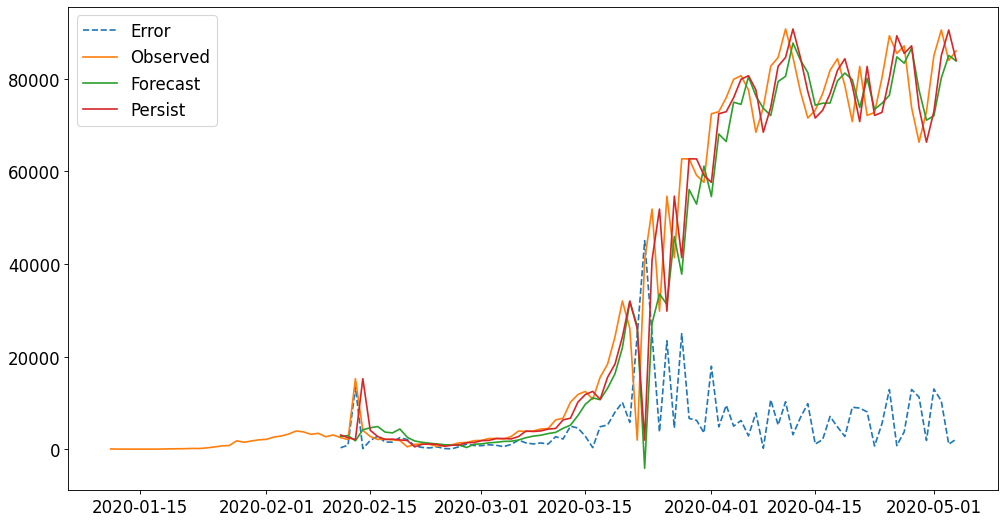

In [9]:
plot_results(series,results,1)

Model MAE: 5724.911081287173 Model ESTD: 7231.993745527071
Persistence MAE: 5166.083333333333 Persistence ESTD: 6798.233440366858


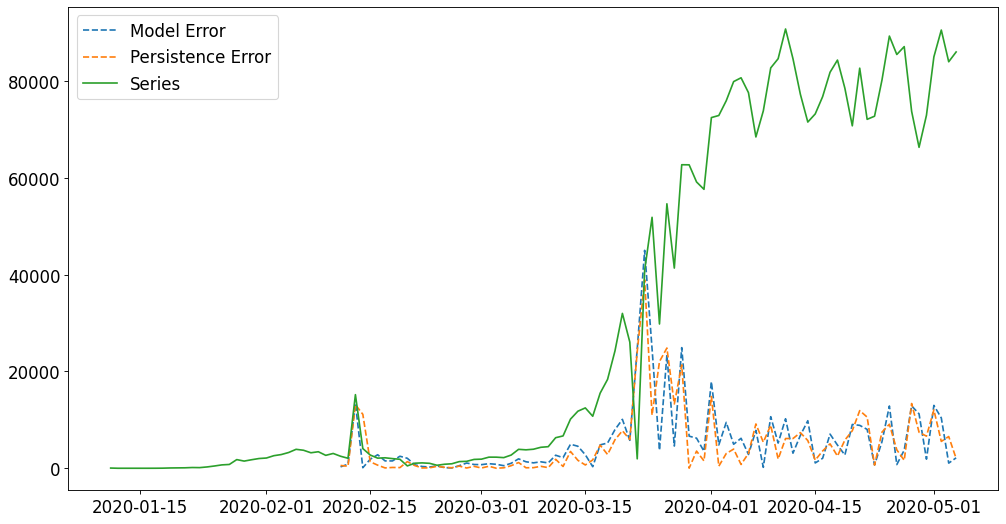

In [10]:
plot_error(series,results,1)